# DeiT: Data-efficient Image Transformer

<img src='https://github.com/facebookresearch/deit/raw/main/.github/deit.png' width='640'>

# About this notebook
- PyTorch `DeiT`: `Data-efficient Image Transformer starter` code

  (Training baseline notebooks are [here](https://www.kaggle.com/yasufuminakama/cassava-resnext50-32x4d-starter-training/) and [here](http://https://www.kaggle.com/yasufuminakama/ranzcr-resnet200d-3-stage-training-step1).)
- TPU or GPU
- StratifiedKFold 5 folds
- 2019 + 2020 dataset


You can see other models.
 - Resnext50_32x4d
 - EfficientNet
 - ViT
 
 <img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbaskhR%2FbtqK3EYp1rv%2FZVqUwtt8aKfHTHdBQJLZgK%2Fimg.png' width='640'>
 
And also there are various Loss Functions
- CrossEntropyLoss
- FocalLoss
- FocalCosineLoss
- SymmetricCrossEntropyLoss
- BiTemperedLoss
- Taylor Cross Entropy Loss

https://www.kaggle.com/piantic/train-cassava-starter-using-various-loss-funcs

If this notebook is helpful, feel free to upvote :)

And please upvote the original notebook as well.


## Updated
**V5** - Add `Get_model()`

**V6** - Add `Taylor Cross Entropy Loss`
- Taylor Cross Entropy Loss

**V7** - Add `Auto Augment`
- Rand Augment

**V8** - Add `Scheduler`
- GradualWarmupSchedulerV2 - [link](https://www.kaggle.com/haqishen/baseline-modified-from-previous-competition)

**V10** - Add `Taylor Cross Entropy Loss with LabelSmoothingLoss` - [link](https://www.kaggle.com/yerramvarun/cassava-taylorce-loss-label-smoothing-combo)

**V12** - Add `CFG.smoothing` in `Taylor Cross Entropy Loss with LabelSmoothingLoss`

**V13** - Add `xm.set_rng_state(CFG.seed, device)` for reproducing results.(This requires more experimentation.)


# Directory settings

In [1]:
# ====================================================
# Directory settings
# ====================================================
import pandas as pd
import seaborn as sns

import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

#TRAIN_PATH = '../input/cassava-leaf-disease-classification/train_images'
TRAIN_PATH = '../input/cassava-leaf-disease-merged/train'
TEST_PATH = '../input/cassava-leaf-disease-classification/test_images'

# Data Loading

In [2]:
os.listdir('../input/cassava-leaf-disease-classification')

['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

In [3]:
train = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
train_merged = pd.read_csv('../input/cassava-leaf-disease-merged/merged.csv')
test = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')
label_map = pd.read_json('../input/cassava-leaf-disease-classification/label_num_to_disease_map.json', 
                         orient='index')
display(label_map)

,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


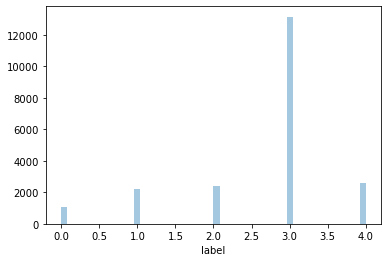

In [4]:
sns.distplot(train['label'], kde=False)

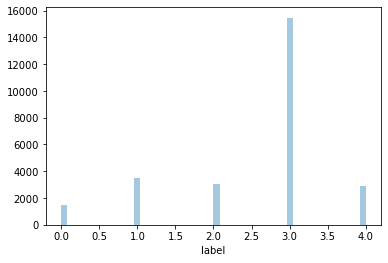

In [5]:
sns.distplot(train_merged['label'], kde=False)

# CFG

In [6]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    apex=False
    device='TPU' # ['TPU', 'GPU']
    nprocs=1 # [1, 8]
    print_freq=100
    num_workers=4
    model_name='deit_base_patch16_224' # ['deit_base_patch16_224', 'vit_base_patch16_384', 'resnext50_32x4d', 'tf_efficientnet_b3_ns']
    size=224 # [224, 384, 512]
    freeze_epo = 0 # GradualWarmupSchedulerV2
    warmup_epo = 1 # GradualWarmupSchedulerV2
    cosine_epo = 19 # GradualWarmupSchedulerV2
    epochs = freeze_epo + warmup_epo + cosine_epo # [GradualWarmupSchedulerV2, n_epochs]
    scheduler='GradualWarmupSchedulerV2' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts', 'GradualWarmupSchedulerV2']
    criterion='TaylorCrossEntropyLoss' # ['CrossEntropyLoss', LabelSmoothing', 'FocalLoss' 'FocalCosineLoss', 'SymmetricCrossEntropyLoss', 'BiTemperedLoss', 'TaylorCrossEntropyLoss']
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    #T_max=10 # CosineAnnealingLR
    T_0=10 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    batch_size=64 #[32, 64, 128]
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    rand_augment=True
    N=3 # RandAugment
    M=11 # RandAugment
    seed=2021
    target_size=5
    target_col='label'
    n_fold=5
    trn_fold=[0] #[0, 1, 2, 3, 4]
    train=True
    smoothing=0.05
    t1=0.3 # bi-tempered-loss https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/202017
    t2=1.0 # bi-tempered-loss https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/202017
    
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

In [7]:
if CFG.device == 'TPU':
    import os
    os.system('curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py')
    os.system('python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev')
    os.system('export XLA_USE_BF16=1')
    os.system('export XLA_TENSOR_ALLOCATOR_MAXSIZE=100000000')
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.distributed.xla_multiprocessing as xmp
    CFG.lr = CFG.lr * CFG.nprocs
    CFG.batch_size = CFG.batch_size // CFG.nprocs
    
!pip install --upgrade pip
if CFG.rand_augment:
    !pip install git+https://github.com/ildoonet/pytorch-randaugment > /dev/null
    from torchvision.transforms import transforms
    from RandAugment import RandAugment
    
if CFG.scheduler == 'GradualWarmupSchedulerV2': 
    !pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git > /dev/null

     |████████████████████████████████| 1.5 MB 2.8 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.1.1
    Uninstalling pip-20.1.1:
      Successfully uninstalled pip-20.1.1


# Library

In [8]:
# ====================================================
# Library
# ====================================================
import sys
sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

import warnings 
warnings.filterwarnings('ignore')


# ======================================
# Device - TPU or GPU
# ======================================

if CFG.device == 'TPU':
    import ignite.distributed as idist
elif CFG.device == 'GPU' and CFG.apex:
    from torch.cuda.amp import autocast, GradScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# If you want to use DeiT, please check timm version==0.3.2
assert timm.__version__ == "0.3.2"

# Utils

In [10]:
# ====================================================
# Utils
# ====================================================

def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=2021):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

# CV split

In [11]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG.target_col]).size())

fold  label
0     0         218
      1         438
      2         477
      3        2631
      4         516
1     0         218
      1         438
      2         477
      3        2631
      4         516
2     0         217
      1         438
      2         477
      3        2632
      4         515
3     0         217
      1         438
      2         477
      3        2632
      4         515
4     0         217
      1         437
      2         478
      3        2632
      4         515
dtype: int64


# Dataset

In [12]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TRAIN_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label
    

class TrainDataset_v2(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TRAIN_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels[idx]).long()
        return image, label

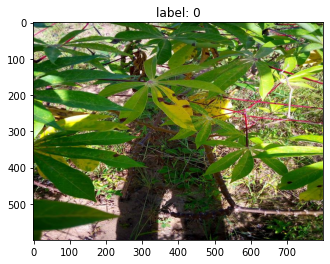

In [13]:
from matplotlib import pyplot as plt

train_dataset = TrainDataset(train, transform=None)

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f'label: {label}')
    plt.show() 

# Transforms

In [14]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            #Resize(CFG.size, CFG.size),
            A.RandomResizedCrop(CFG.size, CFG.size),
            A.Transpose(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    
def get_transforms_v2(*, data):
    
    if data == 'train':
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomResizedCrop((CFG.size, CFG.size)),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomHorizontalFlip(p=0.5),
            RandAugment(CFG.N, CFG.M),
            transforms.Resize((CFG.size, CFG.size)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
        ])

    elif data == 'valid':
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((CFG.size, CFG.size)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
            
        ])

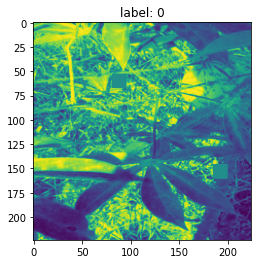

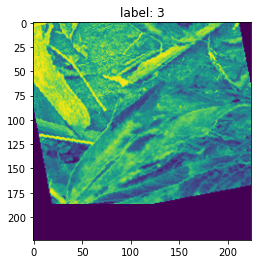

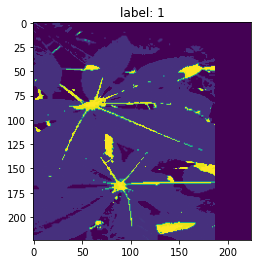

In [15]:
if CFG.rand_augment:
    train_dataset = TrainDataset_v2(train, transform=get_transforms_v2(data='train'))
else:
    train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(3):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

In [16]:
# ====================================================
# MODEL
# ====================================================
class CustomEfficientNet(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model(CFG.model_name, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x
    

class CustomResNext(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x
    
    
class CustomDeiT(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = torch.hub.load('facebookresearch/deit:main', model_name, pretrained=pretrained)
        n_features = self.model.head.in_features
        self.model.head = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

    
class CustomViT(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.head.in_features
        self.model.head = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [17]:
if CFG.model_name=='deit_base_patch16_224':
    model = CustomDeiT(model_name=CFG.model_name, pretrained=False)
elif CFG.model_name=='vit_base_patch16_384':
    model = CustomViT(model_name=CFG.model_name, pretrained=False)
elif CFG.model_name=='resnext50_32x4d':
    model = CustomResNext(CFG.model_name, pretrained=True)
elif CFG.model_name=='tf_efficientnet_b3_ns':
    model = CustomEfficientNet(CFG.model_name, pretrained=True)
    
if CFG.rand_augment:
    train_dataset = TrainDataset_v2(train, transform=get_transforms_v2(data='train'))
else:
    train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

train_dataset = TrainDataset(train, transform=get_transforms(data='train'))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break

Downloading: "https://github.com/facebookresearch/deit/archive/main.zip" to /root/.cache/torch/hub/main.zip


tensor([[-0.1188, -0.4572, -0.2504, -0.2835, -1.1593],
        [ 0.5971, -0.2356,  0.0708, -0.5705, -0.6471],
        [-0.1213, -0.0884,  0.0261,  0.0867, -0.1189],
        [ 0.3570, -0.2874,  0.0497, -0.5778, -0.7241]],
       grad_fn=<AddmmBackward>)


# Criterion

## Label Smoothing

In [18]:
# ====================================================
# Label Smoothing
# ====================================================
class LabelSmoothingLoss(nn.Module): 
    def __init__(self, classes=5, smoothing=0.0, dim=-1): 
        super(LabelSmoothingLoss, self).__init__() 
        self.confidence = 1.0 - smoothing 
        self.smoothing = smoothing 
        self.cls = classes 
        self.dim = dim 
    def forward(self, pred, target): 
        pred = pred.log_softmax(dim=self.dim) 
        with torch.no_grad():
            true_dist = torch.zeros_like(pred) 
            true_dist.fill_(self.smoothing / (self.cls - 1)) 
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence) 
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

## Focal Loss

In [19]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, inputs, targets):
        BCE_loss = nn.CrossEntropyLoss()(inputs, targets)

        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

## FocalCosineLoss

In [20]:
class FocalCosineLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, xent=.1):
        super(FocalCosineLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

        self.xent = xent

        self.y = torch.Tensor([1]).cuda()

    def forward(self, input, target, reduction="mean"):
        cosine_loss = F.cosine_embedding_loss(input, F.one_hot(target, num_classes=input.size(-1)), self.y, reduction=reduction)

        cent_loss = F.cross_entropy(F.normalize(input), target, reduce=False)
        pt = torch.exp(-cent_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * cent_loss

        if reduction == "mean":
            focal_loss = torch.mean(focal_loss)

        return cosine_loss + self.xent * focal_loss

## SymmetricCrossEntropy

In [21]:
class SymmetricCrossEntropy(nn.Module):

    def __init__(self, alpha=0.1, beta=1.0, num_classes=5):
        super(SymmetricCrossEntropy, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.num_classes = num_classes

    def forward(self, logits, targets, reduction='mean'):
        onehot_targets = torch.eye(self.num_classes)[targets].cuda()
        ce_loss = F.cross_entropy(logits, targets, reduction=reduction)
        rce_loss = (-onehot_targets*logits.softmax(1).clamp(1e-7, 1.0).log()).sum(1)
        if reduction == 'mean':
            rce_loss = rce_loss.mean()
        elif reduction == 'sum':
            rce_loss = rce_loss.sum()
        return self.alpha * ce_loss + self.beta * rce_loss

## Bi-Tempered-Loss

In [22]:
def log_t(u, t):
    """Compute log_t for `u'."""
    if t==1.0:
        return u.log()
    else:
        return (u.pow(1.0 - t) - 1.0) / (1.0 - t)

def exp_t(u, t):
    """Compute exp_t for `u'."""
    if t==1:
        return u.exp()
    else:
        return (1.0 + (1.0-t)*u).relu().pow(1.0 / (1.0 - t))

def compute_normalization_fixed_point(activations, t, num_iters):

    """Returns the normalization value for each example (t > 1.0).
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (> 1.0 for tail heaviness).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same shape as activation with the last dimension being 1.
    """
    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations_step_0 = activations - mu

    normalized_activations = normalized_activations_step_0

    for _ in range(num_iters):
        logt_partition = torch.sum(
                exp_t(normalized_activations, t), -1, keepdim=True)
        normalized_activations = normalized_activations_step_0 * \
                logt_partition.pow(1.0-t)

    logt_partition = torch.sum(
            exp_t(normalized_activations, t), -1, keepdim=True)
    normalization_constants = - log_t(1.0 / logt_partition, t) + mu

    return normalization_constants

def compute_normalization_binary_search(activations, t, num_iters):

    """Returns the normalization value for each example (t < 1.0).
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (< 1.0 for finite support).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """

    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations = activations - mu

    effective_dim = \
        torch.sum(
                (normalized_activations > -1.0 / (1.0-t)).to(torch.int32),
            dim=-1, keepdim=True).to(activations.dtype)

    shape_partition = activations.shape[:-1] + (1,)
    lower = torch.zeros(shape_partition, dtype=activations.dtype, device=activations.device)
    upper = -log_t(1.0/effective_dim, t) * torch.ones_like(lower)

    for _ in range(num_iters):
        logt_partition = (upper + lower)/2.0
        sum_probs = torch.sum(
                exp_t(normalized_activations - logt_partition, t),
                dim=-1, keepdim=True)
        update = (sum_probs < 1.0).to(activations.dtype)
        lower = torch.reshape(
                lower * update + (1.0-update) * logt_partition,
                shape_partition)
        upper = torch.reshape(
                upper * (1.0 - update) + update * logt_partition,
                shape_partition)

    logt_partition = (upper + lower)/2.0
    return logt_partition + mu

class ComputeNormalization(torch.autograd.Function):
    """
    Class implementing custom backward pass for compute_normalization. See compute_normalization.
    """
    @staticmethod
    def forward(ctx, activations, t, num_iters):
        if t < 1.0:
            normalization_constants = compute_normalization_binary_search(activations, t, num_iters)
        else:
            normalization_constants = compute_normalization_fixed_point(activations, t, num_iters)

        ctx.save_for_backward(activations, normalization_constants)
        ctx.t=t
        return normalization_constants

    @staticmethod
    def backward(ctx, grad_output):
        activations, normalization_constants = ctx.saved_tensors
        t = ctx.t
        normalized_activations = activations - normalization_constants 
        probabilities = exp_t(normalized_activations, t)
        escorts = probabilities.pow(t)
        escorts = escorts / escorts.sum(dim=-1, keepdim=True)
        grad_input = escorts * grad_output
        
        return grad_input, None, None

def compute_normalization(activations, t, num_iters=5):
    """Returns the normalization value for each example. 
    Backward pass is implemented.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """
    return ComputeNormalization.apply(activations, t, num_iters)

def tempered_sigmoid(activations, t, num_iters = 5):
    """Tempered sigmoid function.
    Args:
      activations: Activations for the positive class for binary classification.
      t: Temperature tensor > 0.0.
      num_iters: Number of iterations to run the method.
    Returns:
      A probabilities tensor.
    """
    internal_activations = torch.stack([activations,
        torch.zeros_like(activations)],
        dim=-1)
    internal_probabilities = tempered_softmax(internal_activations, t, num_iters)
    return internal_probabilities[..., 0]


def tempered_softmax(activations, t, num_iters=5):
    """Tempered softmax function.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature > 1.0.
      num_iters: Number of iterations to run the method.
    Returns:
      A probabilities tensor.
    """
    if t == 1.0:
        return activations.softmax(dim=-1)

    normalization_constants = compute_normalization(activations, t, num_iters)
    return exp_t(activations - normalization_constants, t)

def bi_tempered_binary_logistic_loss(activations,
        labels,
        t1,
        t2,
        label_smoothing = 0.0,
        num_iters=5,
        reduction='mean'):

    """Bi-Tempered binary logistic loss.
    Args:
      activations: A tensor containing activations for class 1.
      labels: A tensor with shape as activations, containing probabilities for class 1
      t1: Temperature 1 (< 1.0 for boundedness).
      t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      label_smoothing: Label smoothing
      num_iters: Number of iterations to run the method.
    Returns:
      A loss tensor.
    """
    internal_activations = torch.stack([activations,
        torch.zeros_like(activations)],
        dim=-1)
    internal_labels = torch.stack([labels.to(activations.dtype),
        1.0 - labels.to(activations.dtype)],
        dim=-1)
    return bi_tempered_logistic_loss(internal_activations, 
            internal_labels,
            t1,
            t2,
            label_smoothing = label_smoothing,
            num_iters = num_iters,
            reduction = reduction)

def bi_tempered_logistic_loss(activations,
        labels,
        t1,
        t2,
        label_smoothing=0.0,
        num_iters=5,
        reduction = 'mean'):

    """Bi-Tempered Logistic Loss.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      labels: A tensor with shape and dtype as activations (onehot), 
        or a long tensor of one dimension less than activations (pytorch standard)
      t1: Temperature 1 (< 1.0 for boundedness).
      t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      label_smoothing: Label smoothing parameter between [0, 1). Default 0.0.
      num_iters: Number of iterations to run the method. Default 5.
      reduction: ``'none'`` | ``'mean'`` | ``'sum'``. Default ``'mean'``.
        ``'none'``: No reduction is applied, return shape is shape of
        activations without the last dimension.
        ``'mean'``: Loss is averaged over minibatch. Return shape (1,)
        ``'sum'``: Loss is summed over minibatch. Return shape (1,)
    Returns:
      A loss tensor.
    """

    if len(labels.shape)<len(activations.shape): #not one-hot
        labels_onehot = torch.zeros_like(activations)
        labels_onehot.scatter_(1, labels[..., None], 1)
    else:
        labels_onehot = labels

    if label_smoothing > 0:
        num_classes = labels_onehot.shape[-1]
        labels_onehot = ( 1 - label_smoothing * num_classes / (num_classes - 1) ) \
                * labels_onehot + \
                label_smoothing / (num_classes - 1)

    probabilities = tempered_softmax(activations, t2, num_iters)

    loss_values = labels_onehot * log_t(labels_onehot + 1e-10, t1) \
            - labels_onehot * log_t(probabilities, t1) \
            - labels_onehot.pow(2.0 - t1) / (2.0 - t1) \
            + probabilities.pow(2.0 - t1) / (2.0 - t1)
    loss_values = loss_values.sum(dim = -1) #sum over classes

    if reduction == 'none':
        return loss_values
    if reduction == 'sum':
        return loss_values.sum()
    if reduction == 'mean':
        return loss_values.mean()

In [23]:
class BiTemperedLogisticLoss(nn.Module): 
    def __init__(self, t1, t2, smoothing=0.0): 
        super(BiTemperedLogisticLoss, self).__init__() 
        self.t1 = t1
        self.t2 = t2
        self.smoothing = smoothing
    def forward(self, logit_label, truth_label):
        loss_label = bi_tempered_logistic_loss(
            logit_label, truth_label,
            t1=self.t1, t2=self.t2,
            label_smoothing=self.smoothing,
            reduction='none'
        )
        
        loss_label = loss_label.mean()
        return loss_label

## TaylorCrossEntropyLoss with Label Smoothing

In [24]:
class TaylorSoftmax(nn.Module):
    '''
    This is the autograd version
    '''
    def __init__(self, dim=1, n=2):
        super(TaylorSoftmax, self).__init__()
        assert n % 2 == 0
        self.dim = dim
        self.n = n

    def forward(self, x):
        '''
        usage similar to nn.Softmax:
            >>> mod = TaylorSoftmax(dim=1, n=4)
            >>> inten = torch.randn(1, 32, 64, 64)
            >>> out = mod(inten)
        '''
        fn = torch.ones_like(x)
        denor = 1.
        for i in range(1, self.n+1):
            denor *= i
            fn = fn + x.pow(i) / denor
        out = fn / fn.sum(dim=self.dim, keepdims=True)
        return out


class TaylorCrossEntropyLoss(nn.Module):
    def __init__(self, n=2, ignore_index=-1, reduction='mean', smoothing=0.05):
        super(TaylorCrossEntropyLoss, self).__init__()
        assert n % 2 == 0
        self.taylor_softmax = TaylorSoftmax(dim=1, n=n)
        self.reduction = reduction
        self.ignore_index = ignore_index
        self.lab_smooth = LabelSmoothingLoss(CFG.target_size, smoothing=smoothing)

    def forward(self, logits, labels):
        log_probs = self.taylor_softmax(logits).log()
        loss = self.lab_smooth(log_probs, labels)
        return loss

# Helper functions

## Scheduler

In [25]:
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

In [26]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.device == 'GPU':
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        if CFG.device == 'GPU':
            with autocast():
                y_preds = model(images)
                loss = criterion(y_preds, labels)
                # record loss
                losses.update(loss.item(), batch_size)
                if CFG.gradient_accumulation_steps > 1:
                    loss = loss / CFG.gradient_accumulation_steps
                scaler.scale(loss).backward()
                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
                if (step + 1) % CFG.gradient_accumulation_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    global_step += 1
        elif CFG.device == 'TPU':
            y_preds = model(images)
            loss = criterion(y_preds, labels)
            # record loss
            losses.update(loss.item(), batch_size)
            if CFG.gradient_accumulation_steps > 1:
                loss = loss / CFG.gradient_accumulation_steps
            loss.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
            if (step + 1) % CFG.gradient_accumulation_steps == 0:
                xm.optimizer_step(optimizer, barrier=True)
                optimizer.zero_grad()
                global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if CFG.device == 'GPU':
            if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
                print('Epoch: [{0}][{1}/{2}] '
                      'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                      'Elapsed {remain:s} '
                      'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                      'Grad: {grad_norm:.4f}  '
                      #'LR: {lr:.6f}  '
                      .format(
                       epoch+1, step, len(train_loader), batch_time=batch_time,
                       data_time=data_time, loss=losses,
                       remain=timeSince(start, float(step+1)/len(train_loader)),
                       grad_norm=grad_norm,
                       #lr=scheduler.get_lr()[0],
                       ))
        elif CFG.device == 'TPU':
            if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
                xm.master_print('Epoch: [{0}][{1}/{2}] '
                                'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                                'Elapsed {remain:s} '
                                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                                'Grad: {grad_norm:.4f}  '
                                #'LR: {lr:.6f}  '
                                .format(
                                epoch+1, step, len(train_loader), batch_time=batch_time,
                                data_time=data_time, loss=losses,
                                remain=timeSince(start, float(step+1)/len(train_loader)),
                                grad_norm=grad_norm,
                                #lr=scheduler.get_lr()[0],
                                ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    trues = []
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        trues.append(labels.to('cpu').numpy())
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if CFG.device == 'GPU':
            if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
                print('EVAL: [{0}/{1}] '
                      'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                      'Elapsed {remain:s} '
                      'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                      .format(
                       step, len(valid_loader), batch_time=batch_time,
                       data_time=data_time, loss=losses,
                       remain=timeSince(start, float(step+1)/len(valid_loader)),
                       ))
        elif CFG.device == 'TPU':
            if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
                xm.master_print('EVAL: [{0}/{1}] '
                                'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                                'Elapsed {remain:s} '
                                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                                .format(
                                step, len(valid_loader), batch_time=batch_time,
                                data_time=data_time, loss=losses,
                                remain=timeSince(start, float(step+1)/len(valid_loader)),
                                ))
    trues = np.concatenate(trues)
    predictions = np.concatenate(preds)
    return losses.avg, predictions, trues

# Train loop

In [27]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    if CFG.rand_augment:
        train_dataset = TrainDataset_v2(train_folds, 
                                 transform=get_transforms_v2(data='train'))
        valid_dataset = TrainDataset_v2(valid_folds, 
                                 transform=get_transforms_v2(data='valid'))
    else:
        train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
        valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))
    
    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    valid_labels = valid_folds[CFG.target_col].values
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='GradualWarmupSchedulerV2':
            scheduler_cosine=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, CFG.cosine_epo)
            scheduler_warmup=GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=CFG.warmup_epo, after_scheduler=scheduler_cosine)
            scheduler=scheduler_warmup
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    if CFG.device == 'TPU':
        device = xm.xla_device()
        xm.set_rng_state(CFG.seed, device)
    elif CFG.device == 'GPU':
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    
    def get_model(pretrained=False):
        if CFG.model_name=='deit_base_patch16_224':
            model = CustomDeiT(model_name=CFG.model_name, pretrained=pretrained)
        elif CFG.model_name=='vit_base_patch16_384':
            model = CustomViT(model_name=CFG.model_name, pretrained=pretrained)
        elif CFG.model_name=='resnext50_32x4d':
            model = CustomResNext(CFG.model_name, pretrained=pretrained)
        elif CFG.model_name=='tf_efficientnet_b3_ns':
            model = CustomEfficientNet(CFG.model_name, pretrained=pretrained)
        return model
    

    model = get_model(pretrained=True)    
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    #if CFG.apex:
    #    model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)
        
        
    # ====================================================
    # Criterion - ['LabelSmoothing', 'FocalLoss' 'FocalCosineLoss', 'SymmetricCrossEntropyLoss', 'BiTemperedLoss', 'TaylorCrossEntropyLoss']
    # ====================================================
    
    def get_criterion():
        if CFG.criterion=='CrossEntropyLoss':
            criterion = nn.CrossEntropyLoss()
        elif CFG.criterion=='LabelSmoothing':
            criterion = LabelSmoothingLoss(classes=CFG.target_size, smoothing=CFG.smoothing)
        elif CFG.criterion=='FocalLoss':
            criterion = FocalLoss().to(device)
        elif CFG.criterion=='FocalCosineLoss':
            criterion = FocalCosineLoss()
        elif CFG.criterion=='SymmetricCrossEntropyLoss':
            criterion = SymmetricCrossEntropy().to(device)
        elif CFG.criterion=='BiTemperedLoss':
            criterion = BiTemperedLogisticLoss(t1=CFG.t1, t2=CFG.t2, smoothing=CFG.smoothing)
        elif CFG.criterion=='TaylorCrossEntropyLoss':
            criterion = TaylorCrossEntropyLoss(smoothing=CFG.smoothing)
        return criterion


    # ====================================================
    # loop 
    # ====================================================
    criterion = get_criterion()
    LOGGER.info(f'Criterion: {criterion}')

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        if CFG.device == 'TPU':
            if CFG.nprocs == 1:
                avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)
            elif CFG.nprocs == 8:
                para_train_loader = pl.ParallelLoader(train_loader, [device])
                avg_loss = train_fn(para_train_loader.per_device_loader(device), model, criterion, optimizer, epoch, scheduler, device)
        elif CFG.device == 'GPU':
            avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)
                
        # eval
        if CFG.device == 'TPU':
            if CFG.nprocs == 1:
                avg_val_loss, preds, _ = valid_fn(valid_loader, model, criterion, device)
            elif CFG.nprocs == 8:
                para_valid_loader = pl.ParallelLoader(valid_loader, [device])
                avg_val_loss, preds, valid_labels = valid_fn(para_valid_loader.per_device_loader(device), model, criterion, device)
                preds = idist.all_gather(torch.tensor(preds)).to('cpu').numpy()
                valid_labels = idist.all_gather(torch.tensor(valid_labels)).to('cpu').numpy()
        elif CFG.device == 'GPU':
            avg_val_loss, preds, _ = valid_fn(valid_loader, model, criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()
        elif isinstance(scheduler, GradualWarmupSchedulerV2):
            scheduler.step(epoch)

        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        if CFG.device == 'GPU':
            LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
            LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        elif CFG.device == 'TPU':
            if CFG.nprocs == 1:
                LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
                LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
            elif CFG.nprocs == 8:
                xm.master_print(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
                xm.master_print(f'Epoch {epoch+1} - Score: {score:.4f}')
        
        if score > best_score:
            best_score = score
            if CFG.device == 'GPU':
                LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
                torch.save({'model': model.state_dict(), 
                            'preds': preds},
                           OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth')
            elif CFG.device == 'TPU':
                if CFG.nprocs == 1:
                    LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
                elif CFG.nprocs == 8:
                    xm.master_print(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
                xm.save({'model': model, 
                         'preds': preds}, 
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth')
    
    if CFG.nprocs != 8:
        check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth')
        valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds

In [28]:
# ====================================================
# main
# ====================================================
def main():
    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.5f}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                if CFG.nprocs != 8:
                    LOGGER.info(f"========== fold: {fold} result ==========")
                    get_result(_oof_df)
                    
        if CFG.nprocs != 8:
            # CV result
            LOGGER.info(f"========== CV ==========")
            get_result(oof_df)
            # save result
            oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)

In [ ]:
if __name__ == '__main__':
    if CFG.device == 'TPU':
        def _mp_fn(rank, flags):
            torch.set_default_tensor_type('torch.FloatTensor')
            a = main()
        FLAGS = {}
        xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=CFG.nprocs, start_method='fork')
    elif CFG.device == 'GPU':
        main()

========== fold: 0 training ==========
Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_patch16_224-b5f2ef4d.pth" to /root/.cache/torch/hub/checkpoints/deit_base_patch16_224-b5f2ef4d.pth


Criterion: TaylorCrossEntropyLoss(
  (taylor_softmax): TaylorSoftmax()
  (lab_smooth): LabelSmoothingLoss()
)


Epoch: [1][0/267] Data 2.095 (2.095) Elapsed 0m 21s (remain 96m 37s) Loss: 1.6027(1.6027) Grad: 5.8823  
Epoch: [1][100/267] Data 0.012 (0.036) Elapsed 1m 34s (remain 2m 35s) Loss: 0.7175(0.9225) Grad: 2.3140  
Epoch: [1][200/267] Data 0.012 (0.025) Elapsed 2m 26s (remain 0m 48s) Loss: 0.6500(0.8450) Grad: 2.2938  
Epoch: [1][266/267] Data 0.008 (0.023) Elapsed 3m 1s (remain 0m 0s) Loss: 0.8017(0.8245) Grad: 2.1558  
EVAL: [0/67] Data 2.024 (2.024) Elapsed 0m 6s (remain 7m 22s) Loss: 0.7992(0.7992) 


Epoch 1 - avg_train_loss: 0.8245  avg_val_loss: 0.6307  time: 227s
Epoch 1 - Score: 0.8414
Epoch 1 - Save Best Score: 0.8414 Model


EVAL: [66/67] Data 0.007 (0.107) Elapsed 0m 45s (remain 0m 0s) Loss: 0.6232(0.6307) 
Epoch: [2][0/267] Data 1.804 (1.804) Elapsed 0m 2s (remain 10m 15s) Loss: 0.6939(0.6939) Grad: 2.4037  
